In [52]:
import numpy as np
import openai
from openai import OpenAI

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import time
import pickle
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_fscore_support, f1_score, hamming_loss


# Estimate price

In [2]:
input_cost = 2.5 / 1e6
output_cost = 10 / 1e6
num_par, tokens_par, tokens_query, cat = 424, 320, 220, 5
batch_discount = 0.5

cost = (((tokens_par + tokens_query) * cat * num_par * batch_discount) * input_cost +
        (num_par * cat * 1 * output_cost))
print(cost)


1.4522000000000002


# Prep data

In [3]:
df = pd.read_csv(r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\coding_trial\testData27022025.csv")
df = df.drop(columns = 'Unnamed: 0')

# remove paragraphs that have been annotated multiple times
# still have to deal with these!!
df = df.drop_duplicates(subset="id", keep="last")

# if we want to leave out batches with more annotation mistakes
# checked ids are those that two annotators have done, and which have then been compared
checked_ids = df.loc[df.checked == 1]['id'].unique()
# reliable ids are those that are from later in the annotation process, so with more experience
reliable_ids = df.loc[df.batch.isin(['batch5','batch4_1','batch4_2','batch2_l','batch2_s','batch2_m'])]['id'].unique()
# decent ids are all ids that are not in one of a few batches that seem particularly problematic
decent_ids = df.loc[~df.batch.isin(['batch3_l','batch2_s'])]['id'].unique()

df.shape


(1535, 69)

In [4]:
# load list with categories of interest
filename = r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\categories_of_interest.txt"
with open(filename, 'r') as file:
    cats = json.load(file)

# load the dictionary to map category column names to gpt names
filename = r'C:\\Users\\conix\\Dropbox\\FNRS project taxonomy\\methods in taxonomy\\data\\category_names_dict.txt'
with open(filename, 'r') as file:
    category_names = json.load(file)

# descriptions of the various categories, used in the first try with gpt4omini
filename = r'C:\\Users\\conix\\Dropbox\\FNRS project taxonomy\\methods in taxonomy\\data\\methods_description_gpt4omini_first_try.txt'
with open(filename, 'r') as file:
    methods_old = json.load(file)

# descriptions of the various categories, used in the second try with gpt4omini
filename = r'C:\\Users\\conix\\Dropbox\\FNRS project taxonomy\\methods in taxonomy\\data\\methods_description_gpt4omini_second_try.txt'
with open(filename, 'r') as file:
    methods = json.load(file)

# hierarchical classification of the categories
filename = r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\classification_categories.txt"
with open(filename, "r") as file:
    classif = json.load(file)

# set up openAI API access

In [5]:
# key linked to our account

key = 'YOUR_OPENAI_API_KEY_HERE'
client = OpenAI(api_key = key)


In [26]:
# try out direct access to the API to tune the prompt

def get_annotation(para, system_prompt):
    response = client.chat.completions.create(
    model="gpt-4o-mini",

    # this determines how deterministic the response is
    # set this quite low for a classification task
    temperature=0.1,
    messages=[
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": para
        }
    ],
    )

    return response.choices[0].message.content

results = {}



for i in range(2):
    para_results = {}
    para = df_gpt['displayed_text'][i]
    id = df_gpt['id'][i]

    for cat, descr in methods.items():
        
        system_prompt = f'''
        Imagine you are a professional taxonomist. Your goal is to judge whether a paragraph from the methods section of a taxonomic research paper discusses {cat}. {descr} You will be provided with a paragraph, and you will output a "1" if yes, and a "0" if not. This is the only output needed. Note, the method may be mentioned either directly or implied by the content. However, please make sure you were conservative. That is, only output "1" if you are very sure that this method was applied. If the paragraph is consistent with the method not having been used, please output "0".
'''
        
        result = get_annotation(para, system_prompt) 
        para_results[cat] = result
        
        
        
    results[id] = para_results

# Try 1: gpt 4o-mini with the batch api

Having established that the prompt works through the direct API, we'll use the batch to get a 50% discount. See [here](https://cookbook.openai.com/examples/batch_processing). Due to rate limits, we have to do this in multiple batches. In particular for 4o, the token limit is very low.

## Get the data through the api

In [6]:
# function to split up the annotated paragraphs into batches of at most 50000 requests and 2 million tokens.

def create_task(row_id, cat, para, system_prompt):
    """Create a single task dictionary for the given chunk."""
    custom_id = f"{row_id}___{cat}"
    return {
        "custom_id": custom_id,
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "gpt-4o-mini",
            "temperature": 0.1,
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": para}
            ],
        }
    }

In [7]:
# dictionary that stores all the batches
tasks = {}

# list that stores the requests within each batch
# there is one request for each category for each annotated paragraph
tasks_list = []

batch_count = 0

for _, row in tqdm(df[['id', 'displayed_text']].iterrows()):

    # the user prompt is the concrete material that the general task has to be applied to
    # in our case the annotated paragraph
    para = row["displayed_text"]
    for cat, descr in methods.items():

        # the system prompt gives general instructions
        # in this case: the category name and description as well as the output we want
        system_prompt = f'''Imagine you are a professional taxonomist. Your goal is to judge whether a paragraph from the methods section of a taxonomic research paper discusses {cat}. {descr} You will be provided with a paragraph, and you will output a "1" if yes, and a "0" if not. This is the only output needed. Note, the method may be mentioned either directly or implied by the content. However, please make sure you are conservative. That is, only output "1" if you are very sure that this method was applied. If the paragraph is consistent with the method not having been used, please output "0".'''

        

        task = create_task(row_id=row['id'], cat=cat, para=para, system_prompt=system_prompt)
        tasks_list.append(task)
        
        # Check if our accumulated tasks exceeds the 2 million tokens threshold.
        # this is also always lower than the 50 000 requests allowed per batch
        total_length = sum(len(t['body']['messages'][0]['content']) + len(t['body']['messages'][1]['content'])
                           for t in tasks_list)

        # assume 4 characters per token on average, and keep some spare room the be sure
        if ((total_length / 4) > 1850000):
            tasks[f"batch_{batch_count}"] = tasks_list.copy()
            tasks_list = []
            batch_count += 1

# Save any remaining tasks.
if tasks_list:
    tasks[f"batch_{batch_count}"] = tasks_list

1535it [00:32, 46.54it/s]


In [8]:
# print total number of requests
print(sum(len(v) for v in tasks.values()))

# check if all batches are within two million tokens
problems = []

for key, batch in tasks.items():
    tokens = np.array([
        len(i['body']['messages'][0]['content']) + len(i['body']['messages'][1]['content'])
        for i in batch
    ])
    total_tokens = tokens.sum() / 4
    if total_tokens > 2000000:
        problems.append(key)

assert not problems, f"Batches {problems} exceed 2 million tokens."
print("All batches within 2 million tokens")

# check if all custom ids are unique, otherwise the api throws an error
problems = []

for task in tasks.keys():
    custom_ids = [i['custom_id'] for i in tasks[task]]
    if len(custom_ids) != len(set(custom_ids)):
        problems.append(task)

assert not problems, f"Duplicate custom_ids found in tasks: {problems}"
print("All tasks have unique custom_ids")

55260
All batches within 2 million tokens
All tasks have unique custom_ids


In [125]:
# write the tasks to json files to upload to the batch api

import json

for batch in tasks.keys():
    file_name = f'batches/batch_tasks_taxonomy_4omini_{batch}.jsonl'

    with open(file_name, 'w') as file:
        for obj in tasks[batch]:
            file.write(json.dumps(obj) + '\n')

In [127]:
# loop through batches, and save the results as they are returned and as a df

batches = list(tasks.keys())

for batch in batches:  
    filename = f'batches/batch_tasks_taxonomy_4omini_{batch}.jsonl'

    # upload the file
    with open(filename, "rb") as f:
        batch_file = client.files.create(
            file=f,
            purpose="batch"
        )

    # start the job
    batch_job = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )

    # get the id to check progress
    job_id = batch_job.id 
    status = client.batches.retrieve(job_id).status
    print('started:')
    print(client.batches.retrieve(job_id))
    print('')
    
    # Wait until the batch job is finished.
    while status in ('in_progress', 'finalizing', 'validating'):
        time.sleep(120)
        status = client.batches.retrieve(job_id).status

    # notify if the hob is completed, and get the result
    if status == 'completed':
        print('completed:')
        print(client.batches.retrieve(job_id))
        result_file_id = client.batches.retrieve(job_id).output_file_id
        result = client.files.content(result_file_id).content

    # indicate if there was an error for a batch
    # typically because of rate limits
    else:
        # Optionally handle other statuses or errors
        print('status was:')
        print(status)
        print(batch)
        print(client.batches.retrieve(job_id))
        print('---')
        continue

    

    # Write the result to a file.
    result_file_name = f'results/batch_tasks_taxonomy_4omini_{batch}.jsonl'
    with open(result_file_name, 'wb') as file:
        file.write(result)

    # Read and parse the JSON lines of the result
    results = []
    with open(result_file_name, 'r') as file:
        for line in file:
            json_object = json.loads(line.strip())
            results.append(json_object)

    # for each paragraph, make a dict entry with a dict for each category
    para_ids = list(set([i['custom_id'].split('___')[0] for i in tasks[batch]]))
    result_dct = {para_id:{method:0 for method in methods.keys()} for para_id in para_ids}
    
    # store the results in the dictionaries
    for i in results:
        cat = i['custom_id'].split('___')[1]
        doc_id = i['custom_id'].split('___')[0]
        responded_value = int(i['response']['body']['choices'][0]['message']['content'])
        if responded_value != 0:
            result_dct[doc_id][cat] = responded_value

    # Save to a pickle file.
    pickle_filename = f'results/results_4omini_{batch}.pkl'
    with open(pickle_filename, "wb") as file:
        pickle.dump(result_dct, file)
    print('saved!')
    print('---')


started:
Batch(id='batch_67bedfa55f708190a5c79dfaebac4af1', completion_window='24h', created_at=1740562341, endpoint='/v1/chat/completions', input_file_id='file-3w1h7f7BrbhTHoYo3FopLz', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1740648741, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

completed:
Batch(id='batch_67bedfa55f708190a5c79dfaebac4af1', completion_window='24h', created_at=1740562341, endpoint='/v1/chat/completions', input_file_id='file-3w1h7f7BrbhTHoYo3FopLz', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1740565455, error_file_id=None, errors=None, expired_at=None, expires_at=1740648741, failed_at=None, finalizing_at=1740564635, in_progress_at=1740562342, metadata=None, output_file_id='file-Lrk9t7R2k8uhioZYuag

## Explore the results

In [157]:
all_batches = {}
count = 0
for i in range(16):
    with open(f"results/dct{i}.pkl", "rb") as file:
        dct = pickle.load(file)
        count += len(dct)
        all_batches.update(dct)


# store the results
df_results = pd.DataFrame(all_batches).T.astype('int').sort_index()

# one category name changed between batches
# the api used the original one, but easier now to work with the new name
df_results = df_results.rename(columns = {'phylogenetic methods for analysing phenotypic data':'phylogenetic analysis and reasoning with phenotypic data'})

# In case we only want to look at some of the samples, use this
# df_results = df_results.loc[df_results.index.isin(decent_batches.id)]

# prepare the annotated data for comparison
df_true = df.set_index('id')
df_true = df_true[cats].rename(columns = category_names).sort_index()
# df_true = df_true.loc[df_true.index.isin(decent_batches.id)]

In [158]:
# check if the two dfs are comparable

def assert_dfs_columns_indices_identical(df1: pd.DataFrame, df2: pd.DataFrame) -> None:
    # Assert that the columns are identical (both names and order)
    assert df1.columns.equals(df2.columns), (
        f"Columns differ:\ndf1 columns: {df1.columns.tolist()}\ndf2 columns: {df2.columns.tolist()}"
    )
    
    # Assert that the indices are identical
    assert df1.index.equals(df2.index), (
        f"Indices differ:\ndf1 index: {df1.index.tolist()}\ndf2 index: {df2.index.tolist()}"
    )

assert_dfs_columns_indices_identical(df_true, df_results)
print("DataFrames have identical columns and indices.")

DataFrames have identical columns and indices.


In [159]:
# the classification is hierarchical and leaf categories should have all parent categories
# update the gpt results accordingly

def recursive_update(df, classif):
    # Go through each item in the classification
    for key, value in classif.items():
        if isinstance(value, list):
            # First process subcategories (go deeper into the hierarchy)
            for v in value:
                if isinstance(v, dict):
                    # Recursively update subcategories first
                    recursive_update(df, v)
            
            # After processing subcategories, update the current category
            sub_categories = [v if isinstance(v, str) else list(v.keys())[0] for v in value]
            df.loc[df[sub_categories].eq(1).any(axis=1), key] = 1
    
    # Return the DataFrame to allow for chaining if needed
    return df

# for that, we have to update the category names in the classification dictionary
def replace_terms(obj, mapping):
    """
    Recursively replaces strings in a nested structure (dicts/lists)
    using the provided mapping dictionary.
    """
    # If the object is a dictionary, iterate over its keys and values.
    if isinstance(obj, dict):
        new_dict = {}
        for key, value in obj.items():
            # Replace key if it's a string.
            new_key = mapping.get(key, key) if isinstance(key, str) else key
            # Recursively replace strings in the value.
            new_dict[new_key] = replace_terms(value, mapping)
        return new_dict
    
    # If the object is a list, process each item.
    elif isinstance(obj, list):
        return [replace_terms(item, mapping) for item in obj]
    
    # If the object is a string, replace it if it exists in the mapping.
    elif isinstance(obj, str):
        return mapping.get(obj, obj)
    
    # For other types, return the object unchanged.
    else:
        return obj

# update using the classification
classif = replace_terms(classif, category_names)
df_results = recursive_update(df_results, classif)

# update categories that are not hierarchically related
df_results['interbreeding or reproduction'] = np.where(df_results['reproductive morphology'] == 1, 1, df_results['interbreeding or reproduction'])
df_results['phylogenetic methods'] = np.where(((df_results['phylogenetic species delimitation'] == 1) | (df_results['phylogenetic tree reconstruction methods'] == 1) | (df_results['distance based phylogenetic tree inference'] == 1) | (df_results['character based phylogenetic tree inference'] == 1) | (df_results['phylogenetic analysis and reasoning with phenotypic data'] == 1)), 1, df_results['phylogenetic methods'])

# drop singletons, as that's a meaningless hierarchy level
df_results = df_results.drop('singletons', axis=1)

F1 Micro: 0.8315
F1 Macro: 0.7841
F1 Weighted: 0.8427
F1 Samples: 0.8042
Hamming loss: 0.0791


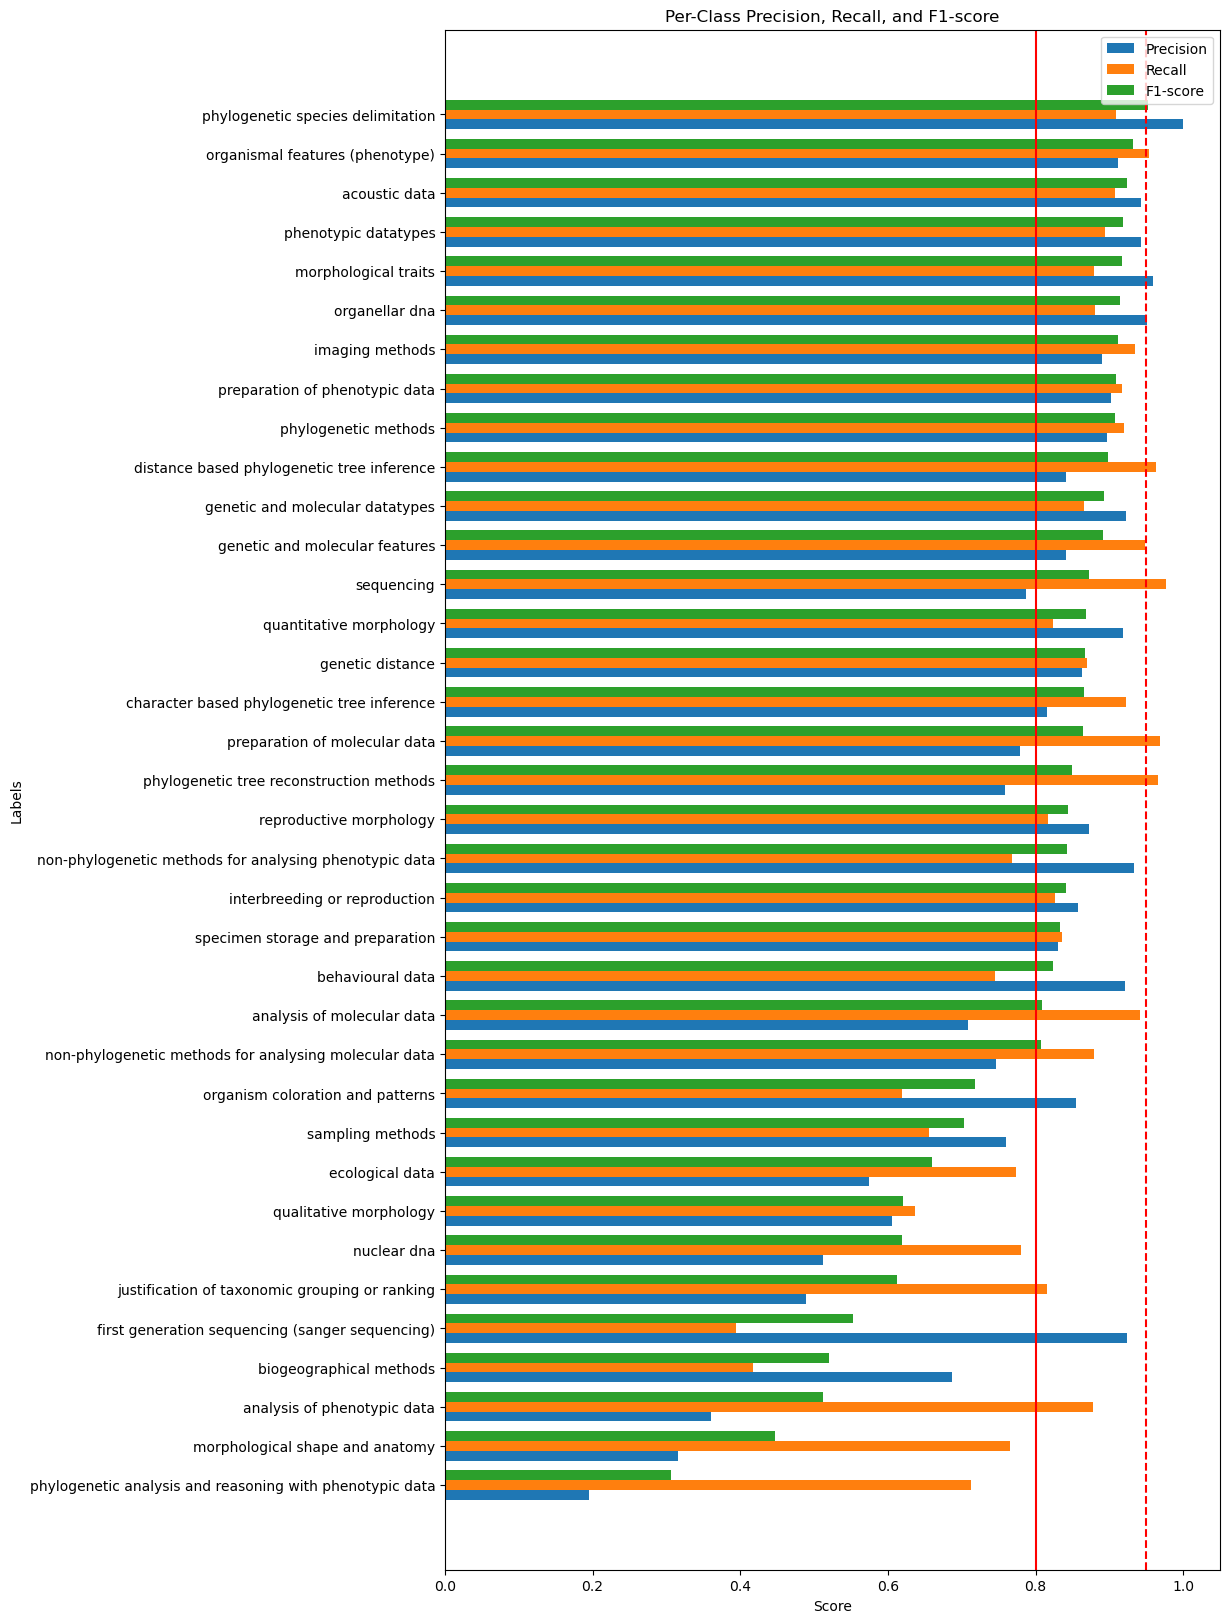

In [160]:
# Compute precision, recall, f1 for each column
precision, recall, f1, _ = precision_recall_fscore_support(df_true, df_results, average=None)

# Store per-column metrics in a DataFrame
df_metrics = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}, index=df_true.columns)
df_metrics = df_metrics.sort_values(by = 'F1-score')

## Compute overall metrics

# first check for all-zeroes on both sides

mask = (df_true.values.sum(axis=1) + df_results.values.sum(axis=1)) > 0

filtered_df_true = df_true.values[mask]
filtered_df_results = df_results.values[mask]

f1_micro = f1_score(filtered_df_true, filtered_df_results, average='micro')
f1_macro = f1_score(filtered_df_true, filtered_df_results, average='macro')
f1_weighted = f1_score(filtered_df_true, filtered_df_results, average='weighted')
f1_samples = f1_score(filtered_df_true, filtered_df_results, average='samples')
hamming_loss_result = hamming_loss(filtered_df_true, filtered_df_results)

# Print overall metrics
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print(f"F1 Samples: {f1_samples:.4f}")
print(f"Hamming loss: {hamming_loss_result:.4f}")



# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 20))

# Bar height and index positions
bar_height = 0.25
y = np.arange(len(df_metrics.index))

# Plot horizontal bars for precision, recall, and F1-score
ax.barh(y - bar_height, df_metrics['Precision'], height=bar_height, label="Precision")
ax.barh(y, df_metrics['Recall'], height=bar_height, label="Recall")
ax.barh(y + bar_height, df_metrics['F1-score'], height=bar_height, label="F1-score")

# Customize chart
ax.set_ylabel("Labels")
ax.set_xlabel("Score")
ax.set_title("Per-Class Precision, Recall, and F1-score")
ax.set_yticks(y)
ax.set_yticklabels(df_metrics.index)
ax.legend(loc = 'upper right')
ax.axvline(0.8, color = 'r')
ax.axvline(0.95, color = 'r', ls = '--')


# Show plot
plt.show()


## Diagnose problems try 1

- in general: problems for longer paragraphs
- perhaps some batches of annotations are worse?


In [ ]:
# function to find mistakes that gpt made per category
def diagnose_gpt(column, problem):
    df1 = df_true
    df2 = df_results[[column]].rename(columns = {column: f"{column}GPT"})
    df_comp = df1.join(df2)

    if problem == 'precision':
        mistakes = df_comp.loc[(df_comp[column] == 0)& (df_comp[f"{column}GPT"] == 1)]
        return mistakes
    elif problem == 'recall':
        mistakes = df_comp.loc[(df_comp[column] == 1)& (df_comp[f"{column}GPT"] == 0)]
        return mistakes
    elif problem == 'both':
        mistakes = df_comp.loc[(df_comp[column] != df_comp[f"{column}GPT"])]
        return mistakes
    else:
        print('Problem should be "recall" or " precision"')

### paragraph length might play a role

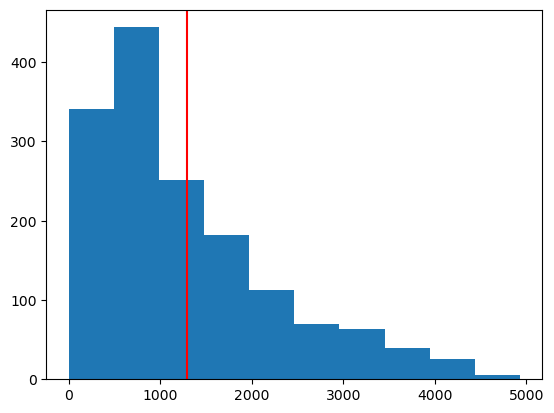

In [104]:
# look at paragraph lengths and their mean
lens = [len(i) for i in df.displayed_text.values]
plt.hist(lens)
plt.axvline(np.mean(lens), color = 'r')
plt.show()

Coefficient for para_len: 0.0005816914647058082
Coefficient for cats_sum: 0.18242268447555468
Intercept: 0.5470099459321487
R-squared: 0.2775119090846403


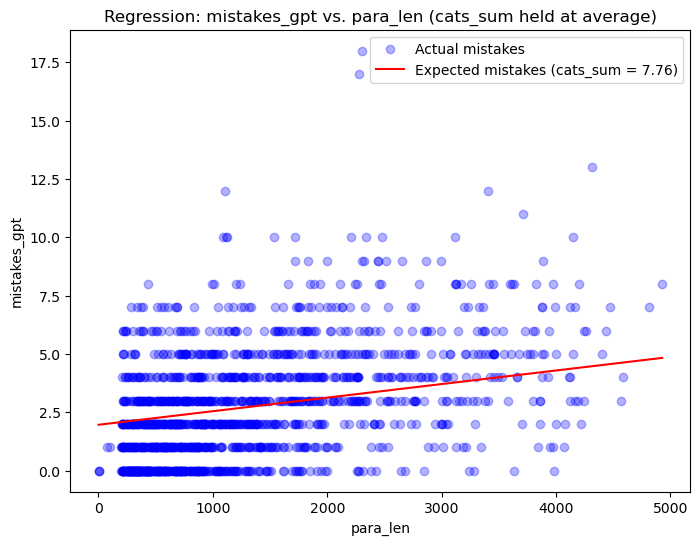

In [102]:
# check whether paragraph length predicts mistakes, independently of how many categories apply

# find mistakes per paragraph
mistakes_dct_para = {i: 0 for i in df.id}
for i in [category_names[k] for k in cats]:
    mistakes = diagnose_gpt(i, 'both')
    for idx in mistakes.index:
        mistakes_dct_para[idx] += 1

# add columns for mistakes and length to the df
df_true['mistakes_gpt'] = df_true.index.map(mistakes_dct_para)
df_true['para_len'] = df_true.index.map({i:len(df.loc[df.id == i, 'displayed_text'].values[0]) for i in df_true.index})

# predictor variables
x1 = df_true.para_len.values
x2 = df_true[[category_names[k] for k in cats]].sum(axis=1).values
X = np.column_stack((x1, x2))

# outcome variable
y = df_true.mistakes_gpt

# Create and fit the multiple linear regression model
model = LinearRegression()
model.fit(X, y)

# Get predictions from the model
y_pred = model.predict(X)

# Print out coefficients and metrics
coef_para_len = model.coef_[0]
coef_cats_sum = model.coef_[1]
intercept = model.intercept_
r_squared = model.score(X, y)

print(f"Coefficient for para_len: {coef_para_len}")
print(f"Coefficient for cats_sum: {coef_cats_sum}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")

# Compute the average cats_sum value
avg_cats = df_true[[category_names[k] for k in cats]].sum(axis=1).mean()

# Create a grid of para_len values for plotting the expected mistakes line
x_grid = np.linspace(x1.min(), x1.max(), 100)
# Calculate the expected mistakes by holding cats_sum equal to its average
predicted_line = model.intercept_ + model.coef_[0] * x_grid + model.coef_[1] * avg_cats

# Plot the actual mistakes vs. para_len and overlay the regression line
plt.figure(figsize=(8, 6))
plt.scatter(x1, y, color='blue', alpha=0.3, label="Actual mistakes")
plt.plot(x_grid, predicted_line, color='red', label=f"Expected mistakes (cats_sum = {avg_cats:.2f})")
plt.xlabel("para_len")
plt.ylabel("mistakes_gpt")
plt.title("Regression: mistakes_gpt vs. para_len (cats_sum held at average)")
plt.legend()
plt.show()

### batch quality might play a role

In [111]:
df_true['batch'] = df_true.index.map({i:df.loc[df.id == i, 'batch'].values[0] for i in df_true.index})

df_true.groupby('batch')[['para_len', 'mistakes_gpt']].mean()

,para_len,mistakes_gpt
batch,,
batch1,1386.670000,2.807500
batch2_l,953.307692,2.264214
batch2_m,1029.788396,2.068259
batch2_s,1135.978947,2.452632
batch3_l,908.470000,2.530000
batch4_1,1707.558559,3.882883
batch4_2,1466.173077,3.500000
batch5,2001.675676,3.556757


Coefficient for para_len: 0.001046069938171607
Coefficients for batch dummies: [ 0.08995867 -0.27595883 -0.00266938  0.31268932  0.82966968  0.69929289
  0.19587648]
Intercept: 1.2669875280719167
R-squared: 0.22510594391530114


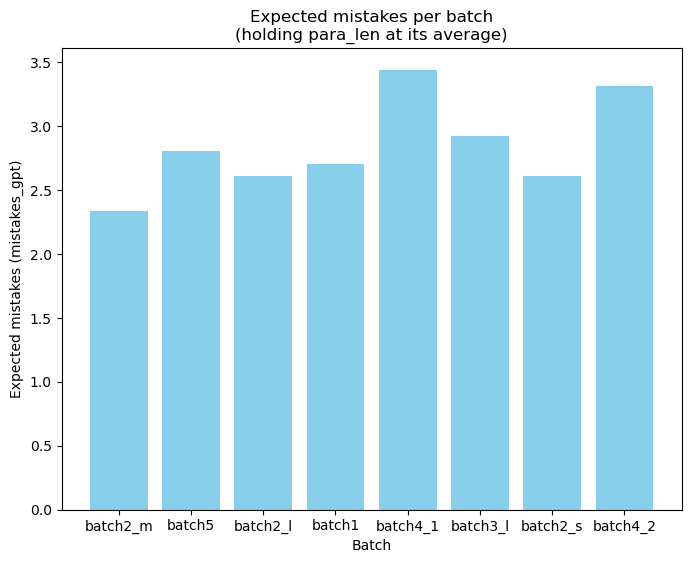

In [119]:
#  We drop the first category to avoid collinearity.
dummy_batch = pd.get_dummies(df_true['batch'], drop_first=False)
dummy_batch = dummy_batch.drop('batch2_l', axis=1)

# Combine predictors
X = pd.concat([df_true['para_len'], dummy_batch], axis=1)
y = df_true['mistakes_gpt']

# fit the multiple linear regression model
model = LinearRegression()
model.fit(X, y)

# coefficients and model metrics
coef_para_len = model.coef_[0]  # Coefficient for para_len
dummy_coefs = model.coef_[1:]   # Coefficients for the dummy variables
intercept = model.intercept_
r_squared = model.score(X, y)

print(f"Coefficient for para_len: {coef_para_len}")
print(f"Coefficients for batch dummies: {dummy_coefs}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")

# Calculate the average paragraph length.
avg_para_len = df_true['para_len'].mean()

# Get the unique batches from the DataFrame.
unique_batches = df_true['batch'].unique()

# Identify the reference category: the one not present among dummy column names.
ref_cat = [cat for cat in unique_batches if cat not in dummy_batch.columns]
if len(ref_cat) >= 1:
    ref_cat = ref_cat[0]
else:
    ref_cat = None

# Build a DataFrame for prediction.
# The columns must match the predictors used in the model.
# For each batch, set para_len to its average and dummy columns appropriately.
prediction_data = []
for batch in unique_batches:
    row = {}
    row['para_len'] = avg_para_len
    # For each dummy column, assign 1 if this batch matches the dummy column name, else 0.
    for col in dummy_batch.columns:
        row[col] = 1 if batch == col else 0
    prediction_data.append(row)
    
prediction_df = pd.DataFrame(prediction_data, index=unique_batches)

# Use the model to predict the expected mistakes for each batch.
predicted_mistakes = model.predict(prediction_df)

# --- Plotting ---

plt.figure(figsize=(8, 6))
plt.bar(unique_batches, predicted_mistakes, color='skyblue')
plt.xlabel("Batch")
plt.ylabel("Expected mistakes (mistakes_gpt)")
plt.title("Expected mistakes per batch\n(holding para_len at its average)")
plt.show()

## phylo methods for phenotypic data

In [111]:
df1 = df[['displayed_text', 'phen_pylo', 'id', 'phylo_tree','character_based']].set_index('id')
df2 = df_pred[['phen_pylo']].rename(columns = {'phen_pylo': 'phen_pyloGPT'})
df_comp = df1.join(df2)

In [112]:
# it is mostly precision that is the issue
mistakes = df_comp.loc[(df_comp.phen_pylo == 0)& (df_comp.phen_pyloGPT == 1)]

In [113]:
# upon review, it seems that the model counted it mistakenly as '1' if there were phylogenetic molecular methods involved. 
# check for this, and change the definition

print('proportion of mistakes that also had molecular phylogenetic methods:')
print(len(mistakes.loc[(mistakes.phylo_tree == 1) | (mistakes.character_based == 1)]) / len(mistakes))

proportion of mistakes that also had molecular phylogenetic methods:
0.8711340206185567


## Justification

there seem to be a lot of mistakes in the annotated samples. Clearly gpt takes a broader view, but often it seems correct upon review. Add one line to the definition telling it to be stricter, but also review the samples.

In [125]:
# it is mostly precision that is the issue
mistakes = diagnose_gpt('justification of taxonomic grouping or ranking','precision')
len(mistakes)
df.loc[df.id.isin(mistakes.index), 'displayed_text'].head()

74

## Nuclear DNA

In most gpt mistakes, there is mention of sequencing but it is not clear whether it is nuclear or organellar. Adapt prompt for this.

In [192]:
# it is mostly precision that is the issue
mistakes = diagnose_gpt('nuclear dna','precision')
len(mistakes)


17

## Shape

This probably just is a category that is a bit too vague.

In [132]:
# it is mostly precision that is the issue
mistakes = diagnose_gpt('morphological shape and anatomy','precision')
len(mistakes)

276

## Biogeo

- precision: any mention of geography seems to be enough for gpt to give a '1'
- recall: mention of 'sympatric' or 'allopatric' or 'paleogeographical' should be enough for biogeographical reasoning, but wasn't.
- a lot of annotation mistakes, somewhat vague category

In [134]:
# precision first
mistakes = diagnose_gpt('biogeographical methods','precision')
len(mistakes)

15

In [135]:
# recall
mistakes = diagnose_gpt('biogeographical methods','recall')
len(mistakes)

46

## Sampling

In [137]:
# recall
mistakes = diagnose_gpt('sampling methods','recall')
len(mistakes)

133

## Color pattern

In [141]:
# recall

mistakes = diagnose_gpt("organism coloration and patterns", "recall")
len(mistakes)

54

## sequencing

- a lot of mistakes
- gpt requires less to assume it

In [143]:
# precision
mistakes = diagnose_gpt("sequencing", "precision")
len(mistakes)

70

## non phylo methods phenotype

In [144]:
mistakes = diagnose_gpt("non-phylogenetic methods for analysing phenotypic data", "recall")
len(mistakes)

34

# Second try: o4-mini with shorter paragraphs and changes to the definitions

Given that paragraph length was a problem, it is worth trying the same with long paragraphs split up. In addition, we've made small changes to some of the definition to avoid some of the problems diagnosed above.

## Get the data theough the api

In [147]:
# function to split long paragraphs into shorter chunks
def split_text(s, n):
    """Split string s into n roughly equal parts."""
    chunk_size = len(s) // n
    parts = [ s[i * chunk_size: (i + 1) * chunk_size] for i in range(n - 1) ]
    parts.append(s[(n - 1) * chunk_size:])
    return parts

In [148]:
# new version of this function, to deal with the chunks
# importantly, each chunk needs a unique id for the batch api

def create_task2(row_id, cat, system_prompt, chunk, index_suffix=""):
    """Create a single task dictionary for the given chunk."""
    custom_id = f"{row_id}___{cat}" + (f"___{index_suffix}" if index_suffix != "" else "")
    return {
        "custom_id": custom_id,
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "gpt-4o-mini",
            "temperature": 0.1,
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": chunk}
            ],
        }
    }

tasks = {}
tasks_list = []
batch_count = 0

for _, row in tqdm(df[['id', 'displayed_text']].iterrows()):
    para = row["displayed_text"]
    for cat, descr in methods.items():
        system_prompt = f'''Imagine you are a professional taxonomist. Your goal is to judge whether a paragraph from the methods section of a taxonomic research paper discusses {cat}. {descr} You will be provided with a paragraph, and you will output a "1" if yes, and a "0" if not. This is the only output needed. Note, the method may be mentioned either directly or implied by the content. However, please make sure you are conservative. That is, only output "1" if you are very sure that this method was applied. If the paragraph is consistent with the method not having been used, please output "0".'''

        
        # Determine the number of chunks based on paragraph length.
        if len(para) < 1800:
            parts = [para]
        elif len(para) < 3600:
            parts = split_text(para, 2)
        else:
            parts = split_text(para, 3)
        
        # Create a task for each chunk.
        for i, chunk in enumerate(parts):
            task = create_task2(row_id=row['id'], cat=cat, system_prompt=system_prompt, chunk=chunk, index_suffix=str(i) if len(parts) > 1 else "")
            tasks_list.append(task)
            
            # Check if our accumulated tasks exceed a threshold.
            total_length = sum(len(t['body']['messages'][0]['content']) + len(t['body']['messages'][1]['content'])
                               for t in tasks_list)
            if ((total_length / 4) > 1850000) & (i == len(parts) - 1):
                tasks[f"batch_{batch_count}"] = tasks_list.copy()
                tasks_list = []
                batch_count += 1

# Save any remaining tasks.
if tasks_list:
    tasks[f"batch_{batch_count}"] = tasks_list


1535it [00:47, 32.64it/s]


In [ ]:
# get the data
for i in batches:
    filename = f'batches/batch_tasks_taxonomy_4omini_secondTry_{batch}.jsonl'
    
    batch_file = client.files.create(
        file=open(filename, "rb"),
        purpose="batch"
    )
    
    batch_job = client.batches.create(
      input_file_id=batch_file.id,
      endpoint="/v1/chat/completions",
      completion_window="24h"
    )

    id = batch_job.id
    status = client.batches.retrieve(id).status
    while (status == 'in progress') or (status == 'finalizing'):
        time.sleep(120)
        status = client.batches.retrieve(id).status

    if status == 'completed':
        result_file_id = client.batches.retrieve(id).output_file_id
        result = client.files.content(result_file_id).content


    result_file_name = f'results/batch_tasks_taxonomy_4omini_secondTry_{batch}.jsonl'

    with open(result_file_name, 'wb') as file:
        file.write(result)

    results = []
    with open(result_file_name, 'r') as file:
        for line in file:
            # Parsing the JSON string into a dict and appending to the list of results
            json_object = json.loads(line.strip())
            results.append(json_object)


    ids = list(set([i['custom_id'].split('___')[0] for i in tasks[batch]]))
    result_dct = {i:{method:0 for method in methods.keys()} for i in ids}
    
    
    for i in results:
        cat = i['custom_id'].split('___')[1]
        id = i['custom_id'].split('___')[0]
        result_dct[id][cat] = i['response']['body']['choices'][0]['message']['content']


    
    
    # Save to a pickle file
    with open(f'results/results_4omini_secondTry_{batch}.pkl', "wb") as file:
        pickle.dump(result_dct, file)

## Explore the results

In [252]:
all_batches = {}
count = 0
for i in range(18):
    with open(f"results/results_4omini_secondTry_batch_{i}.pkl", "rb") as file:
        dct = pickle.load(file)
        count += len(dct)
        all_batches.update(dct)


# store the results
df_results = pd.DataFrame(all_batches).T.astype('int').sort_index()

# one category name changed between batches
# the api used the original one, but easier now to work with the new name
df_results = df_results.rename(columns = {'phylogenetic methods for analysing phenotypic data':'phylogenetic analysis and reasoning with phenotypic data'})

# In case we only want to look at some of the samples, use this
# df_results = df_results.loc[df_results.index.isin(decent_batches.id)]

# prepare the annotated data for comparison
df_true = df.set_index('id')
df_true = df_true[cats].rename(columns = category_names).sort_index()

# df_true = df_true.loc[df_true.index.isin(decent_batches.id)]

In [253]:
# check if the two dfs are comparable

assert_dfs_columns_indices_identical(df_true, df_results)
print("DataFrames have identical columns and indices.")

DataFrames have identical columns and indices.


In [254]:
# the classification is hierarchical and leaf categories should have all parent categories
# update the gpt results accordingly

classif = replace_terms(classif, category_names)
df_results = recursive_update(df_results, classif)

# update categories that are not hierarchically related
df_results['interbreeding or reproduction'] = np.where(df_results['reproductive morphology'] == 1, 1, df_results['interbreeding or reproduction'])
df_results['phylogenetic methods'] = np.where(((df_results['phylogenetic species delimitation'] == 1) | (df_results['phylogenetic tree reconstruction methods'] == 1) | (df_results['distance based phylogenetic tree inference'] == 1) | (df_results['character based phylogenetic tree inference'] == 1) | (df_results['phylogenetic analysis and reasoning with phenotypic data'] == 1)), 1, df_results['phylogenetic methods'])

# drop singletons, as that's a meaningless hierarchy level
df_results = df_results.drop('singletons', axis=1)

F1 Micro: 0.8455
F1 Macro: 0.7967
F1 Weighted: 0.8494
F1 Samples: 0.8113
Hamming loss: 0.0708


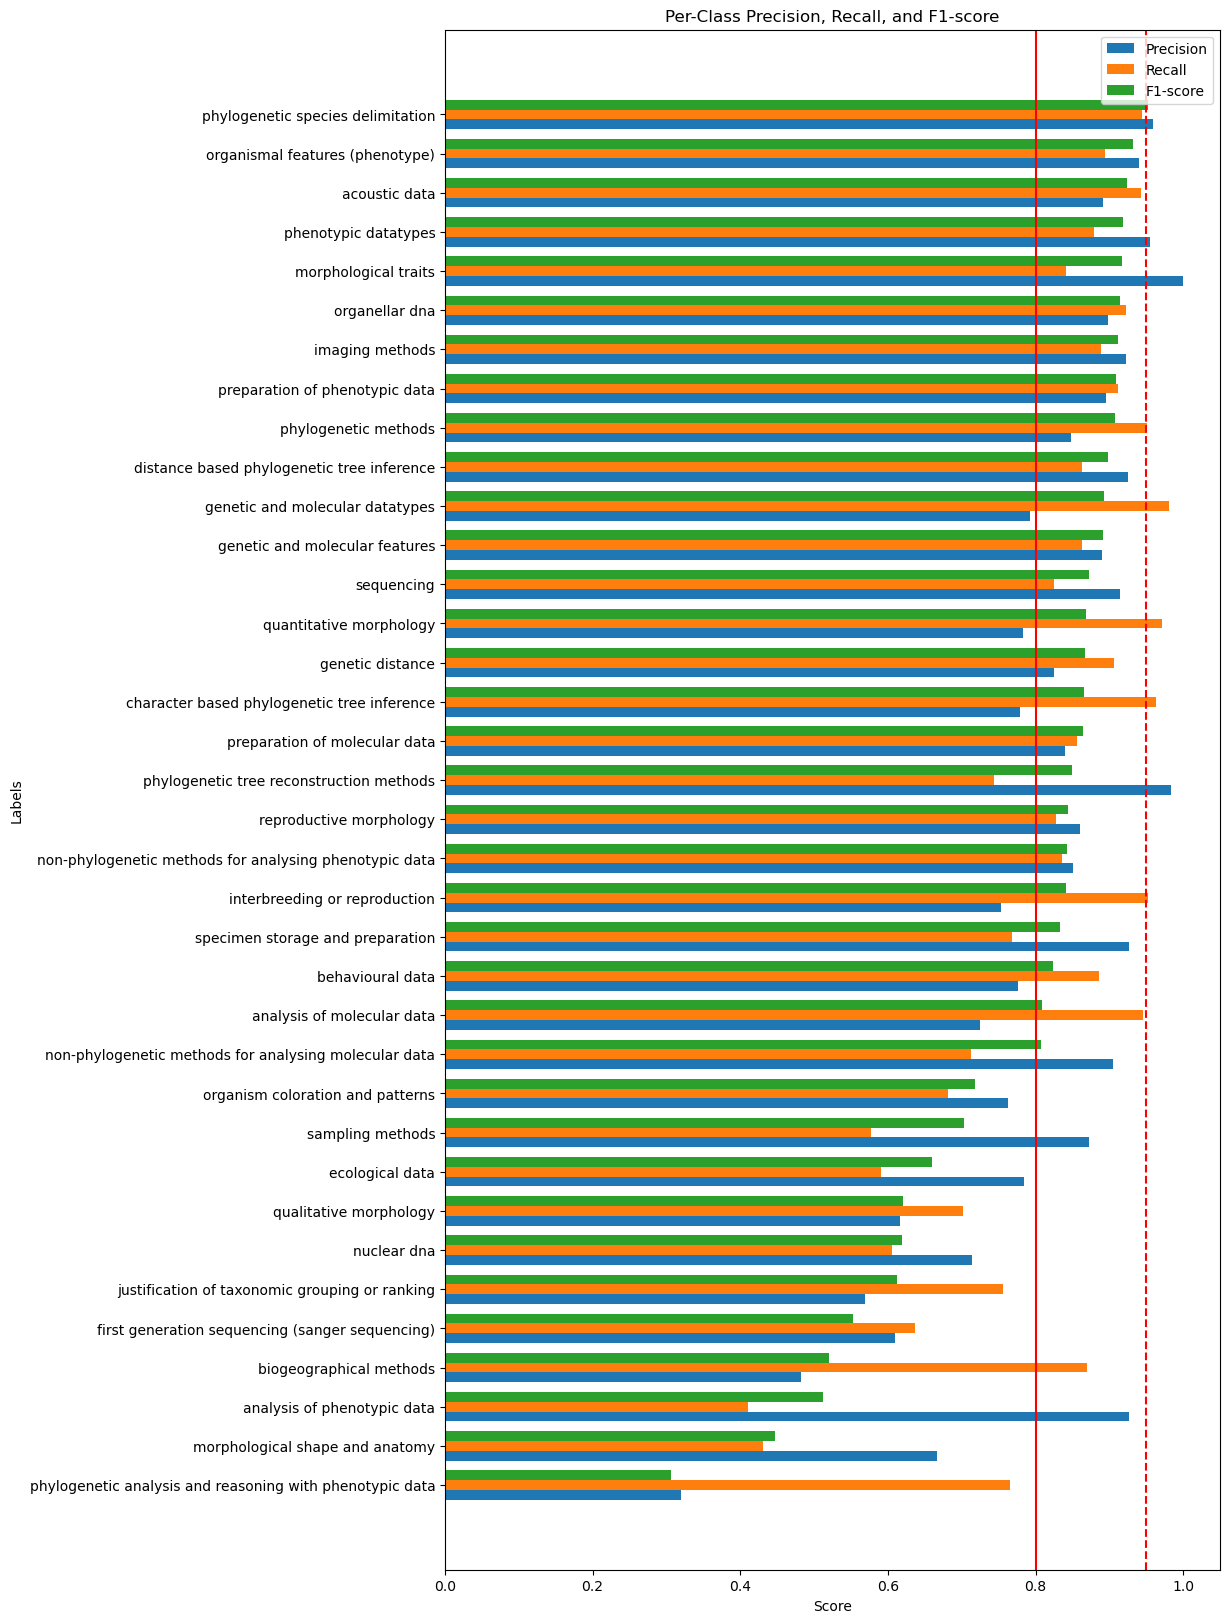

In [255]:
# Compute precision, recall, f1 for each column
precision, recall, f1, _ = precision_recall_fscore_support(df_true, df_results, average=None)

# Store per-column metrics in a DataFrame
df_metrics2 = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}, index=df_true.columns)
df_metrics2 = df_metrics2.sort_values(by = 'F1-score')

## Compute overall metrics

# first check for all-zeroes on both sides

mask = (df_true.values.sum(axis=1) + df_results.values.sum(axis=1)) > 0

filtered_df_true = df_true.values[mask]
filtered_df_results = df_results.values[mask]

f1_micro = f1_score(filtered_df_true, filtered_df_results, average='micro')
f1_macro = f1_score(filtered_df_true, filtered_df_results, average='macro')
f1_weighted = f1_score(filtered_df_true, filtered_df_results, average='weighted')
f1_samples = f1_score(filtered_df_true, filtered_df_results, average='samples')
hamming_loss_result = hamming_loss(filtered_df_true, filtered_df_results)

# Print overall metrics
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print(f"F1 Samples: {f1_samples:.4f}")
print(f"Hamming loss: {hamming_loss_result:.4f}")



# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 20))

# Bar height and index positions
bar_height = 0.25
y = np.arange(len(df_metrics.index))

# Plot horizontal bars for precision, recall, and F1-score
ax.barh(y - bar_height, df_metrics2['Precision'], height=bar_height, label="Precision")
ax.barh(y, df_metrics2['Recall'], height=bar_height, label="Recall")
ax.barh(y + bar_height, df_metrics2['F1-score'], height=bar_height, label="F1-score")

# Customize chart
ax.set_ylabel("Labels")
ax.set_xlabel("Score")
ax.set_title("Per-Class Precision, Recall, and F1-score")
ax.set_yticks(y)
ax.set_yticklabels(df_metrics.index)
ax.legend(loc = 'upper right')
ax.axvline(0.8, color = 'r')
ax.axvline(0.95, color = 'r', ls = '--')


# Show plot
plt.show()


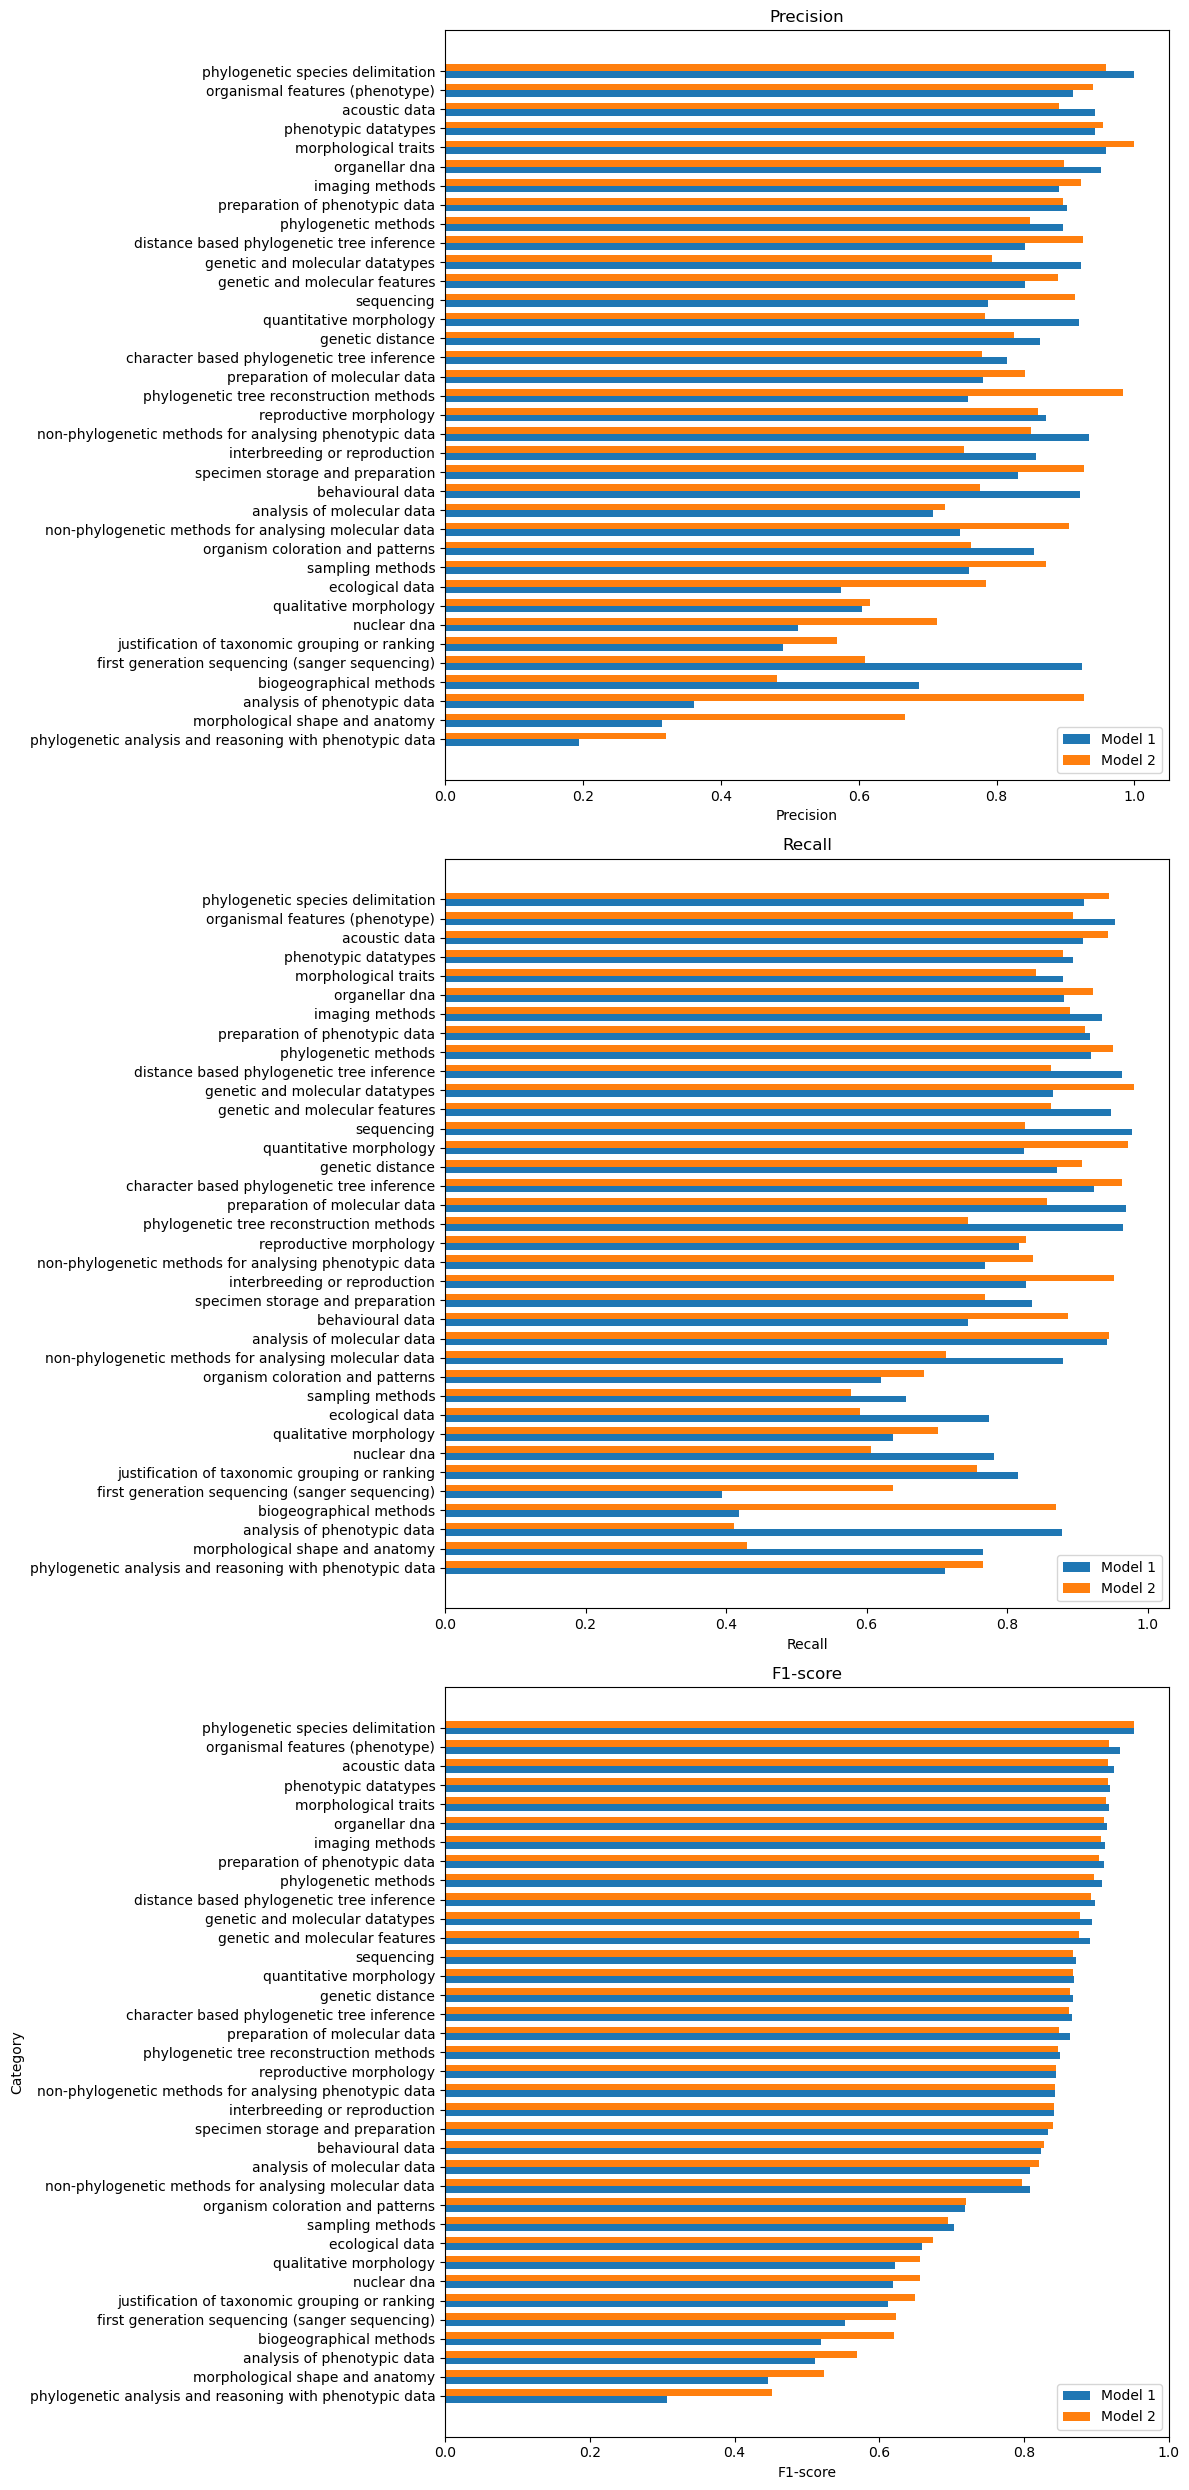

In [245]:
metrics = ["Precision", "Recall", "F1-score"]

# Create subplots: one row per metric.
n_metrics = len(metrics)
y = np.arange(len(df_metrics.index))  # the y locations for the groups
bar_height = 0.35  # height of the bars

fig, axes = plt.subplots(n_metrics, 1, figsize=(12,25), sharey=True)

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.barh(y - bar_height/2, df_metrics[metric].values, height=bar_height, label="Model 1")
    ax.barh(y + bar_height/2, df_metrics2[metric].values, height=bar_height, label="Model 2")
    ax.set_title(metric)
    ax.set_xlabel(metric)
    ax.set_yticks(y)
    ax.set_yticklabels(df_metrics.index)
    ax.legend()

plt.ylabel("Category")
plt.tight_layout()
plt.show()


## Diagnosis run 2

check biogeo, color_pattern, ecology, nuclear, phen_pylo, rank_just

In [223]:
df_results['displayed_text'] = df_results.index.map({i:df.loc[df.id == i, 'displayed_text'].values[0] for i in df_results.index})
df_true['displayed_text'] = df_true.index.map({i:df.loc[df.id == i, 'displayed_text'].values[0] for i in df_true.index})


### Biogeo

- still annotation mistakes; in general, gpt is stricter on the reasoning, while human annotators had included even just mentions of distributions.
- yet, some of the precision issues lie in including passages that only mention making a distribution map or map of sampling locations. The precision mistakes generally seem more random, though, and less an issue of annotation errors.

In [198]:
# recall

mistakes = diagnose_gpt("biogeographical methods", "recall")

len(mistakes)

45

In [199]:
# precision

mistakes = diagnose_gpt("biogeographical methods", "precision")


### Color pattern

- Most mistakes are recall mistakes where there are no color terms but rather things like 'pale', or 'color terminology is borrowed from...'

In [201]:
# recall

mistakes = diagnose_gpt("organism coloration and patterns", "recall")



### ecology

- clearly, the problem is precision, with gpt counting anything like 'preserved atlantic rain forest' or 'hemlock dominated mid-elevation forests' as sufficient, and human annotators needings more.

In [203]:
# precision

mistakes = diagnose_gpt("ecological data", "precision")



### Nuclear

- a lot of the ribosomalRNA genes, like its, 18S and 28S that dont get counted. Adapt definition.

In [224]:
# recall

mistakes = diagnose_gpt("nuclear dna", "recall")


In [225]:
# check for how many of them the ribosomal ones weren't counted
count = sum(1 for i in mistakes.displayed_text.values if '18s' in i.lower() or '28s' in i.lower() or 'its' in i.lower())
count/len(mistakes)

0.627906976744186

### Phen phylogenetic methods

- recall: no annotation mistakes, but slightly more subtle cases of phylogenetic reasoning going unnoticed, such as mentioning that two traits are homologies. Make the definition a bit more inclusive to get more emphasis onto these.
- precision: more annotation mistakes, as well as some subtle cases.

In [228]:
# recall

mistakes = diagnose_gpt("phylogenetic analysis and reasoning with phenotypic data", "recall")


In [229]:
# precision

mistakes = diagnose_gpt("phylogenetic analysis and reasoning with phenotypic data", "precision")


### Rank justification

- recall: all rather subtle cases that gpt missed
- precision: mostly annotation mistakes

In [230]:
# recall

mistakes = diagnose_gpt("justification of taxonomic grouping or ranking", "recall")


In [231]:
# precision

mistakes = diagnose_gpt("justification of taxonomic grouping or ranking", "precision")


# Third try: gpt 4o

The rate limits are far lower, and even just doing the annotated samples would take very long. We therefore take the ones that 4o-mini got wrong for the worst categories, and see if there is a large difference.

## Get the data through the api

In [246]:
# try with selected method and samples

# the methods: the ones that performed badly
methods_bad = ['rank_just', 'biogeo', 'color_pattern', 'phen_pylo', 'nuclear']
methods_bad_new_names = [category_names[k] for k in methods_bad]
short_methods = {k:methods[k] for k in methods_bad_new_names}

# the paragraphs: the ones that were mistakes for these

fouro_ids = []

for i in methods_bad_new_names:
    mistakes_ids = diagnose_gpt(i, "both").index
    for i in mistakes_ids:
        fouro_ids.append(i)

len(set(fouro_ids))

261

In [235]:
fouro_df = df.loc[df.id.isin(fouro_ids)]



tasks = {}
tasks_list = []
batch_count = 0

for _, row in tqdm(fouro_df[['id', 'displayed_text']].iterrows()):
    para = row["displayed_text"]
    for cat, descr in short_methods.items():
        system_prompt = f'''Imagine you are a professional taxonomist. Your goal is to judge whether a paragraph from the methods section of a taxonomic research paper discusses {cat}. {descr} You will be provided with a paragraph, and you will output a "1" if yes, and a "0" if not. This is the only output needed. Note, the method may be mentioned either directly or implied by the content. However, please make sure you are conservative. That is, only output "1" if you are very sure that this method was applied. If the paragraph is consistent with the method not having been used, please output "0".'''

        
        # Determine the number of chunks based on paragraph length.
        if len(para) < 1800:
            parts = [para]
        elif len(para) < 3600:
            parts = split_text(para, 2)
        else:
            parts = split_text(para, 3)
        
        # Create a task for each chunk.
        for i, chunk in enumerate(parts):
            task = create_task2(row_id=row['id'], cat=cat, system_prompt=system_prompt, chunk=chunk, index_suffix=str(i) if len(parts) > 1 else "")
            tasks_list.append(task)
            
            # Check if our accumulated tasks exceed a threshold.
            total_length = sum(len(t['body']['messages'][0]['content']) + len(t['body']['messages'][1]['content'])
                               for t in tasks_list)
            if ((total_length / 4) > 87000) & (i == len(parts) - 1):
                tasks[f"batch_{batch_count}"] = tasks_list.copy()
                tasks_list = []
                batch_count += 1

# Save any remaining tasks.
if tasks_list:
    tasks[f"batch_{batch_count}"] = tasks_list

261it [00:00, 2484.77it/s]


In [240]:
# print total number of requests
print(sum(len(v) for v in tasks.values()))

# check if all batches are within two million tokens
problems = []

for key, batch in tasks.items():
    tokens = np.array([
        len(i['body']['messages'][0]['content']) + len(i['body']['messages'][1]['content'])
        for i in batch
    ])
    total_tokens = tokens.sum() / 4
    if total_tokens > 90000:
        problems.append(key)

assert not problems, f"Batches {problems} exceed 2 million tokens."
print("All batches within 90k tokens")

# check if all custom ids are unique, otherwise the api throws an error
problems = []

for task in tasks.keys():
    custom_ids = [i['custom_id'] for i in tasks[task]]
    if len(custom_ids) != len(set(custom_ids)):
        problems.append(task)

assert not problems, f"Duplicate custom_ids found in tasks: {problems}"
print("All tasks have unique custom_ids")

2000
All batches within 90k tokens
All tasks have unique custom_ids


In [71]:
# write to json file

import json

for batch in tasks.keys():
    file_name = f'batches/batch_tasks_taxonomy_4o_thirdTry_{batch}.jsonl'

    with open(file_name, 'w') as file:
        for obj in tasks[batch]:
            file.write(json.dumps(obj) + '\n')



In [80]:
# loop through batches

batches = list(tasks.keys())

for batch in batches:  
    filename = f'batches/batch_tasks_taxonomy_4o_thirdTry_{batch}.jsonl'
    
    with open(filename, "rb") as f:
        batch_file = client.files.create(
            file=f,
            purpose="batch"
        )
    
    batch_job = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )

    job_id = batch_job.id 
    status = client.batches.retrieve(job_id).status
    print('started:')
    print(client.batches.retrieve(job_id))
    print('')
    
    # Wait until the batch job is finished.
    while status in ('in_progress', 'finalizing', 'validating'):
        time.sleep(120)
        status = client.batches.retrieve(job_id).status
        
    if status == 'completed':
        print('completed:')
        print(client.batches.retrieve(job_id))
        result_file_id = client.batches.retrieve(job_id).output_file_id
        result = client.files.content(result_file_id).content

    

    else:
        # Optionally handle other statuses or errors
        print('status was:')
        print(status)
        print(batch)
        print(client.batches.retrieve(job_id))
        print('---')
        continue

    result_file_name = f'results/batch_tasks_taxonomy_4o_thirdTry_{batch}.jsonl'

    # Write the result to a file.
    with open(result_file_name, 'wb') as file:
        file.write(result)

    # Read and parse the JSON lines.
    results = []
    with open(result_file_name, 'r') as file:
        for line in file:
            json_object = json.loads(line.strip())
            results.append(json_object)
    
    para_ids = list(set([i['custom_id'].split('___')[0] for i in tasks[batch]]))
    result_dct = {para_id:{method:0 for method in methods.keys()} for para_id in para_ids}
    
    
    for i in results:
        cat = i['custom_id'].split('___')[1]
        doc_id = i['custom_id'].split('___')[0]
        responded_value = int(i['response']['body']['choices'][0]['message']['content'].strip('"'))
        if responded_value != 0:
            result_dct[doc_id][cat] = responded_value

    # Save to a pickle file.
    pickle_filename = f'results/results_4o_thirdTry_{batch}.pkl'
    with open(pickle_filename, "wb") as file:
        pickle.dump(result_dct, file)
    print('saved!')
    print('---')


started:
Batch(id='batch_67c55f22dcbc8190b875b622ae1dbf7d', completion_window='24h', created_at=1740988194, endpoint='/v1/chat/completions', input_file_id='file-LPXEPYxZvsCwDo6Tzhz5tE', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1741074594, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

completed:
Batch(id='batch_67c55f22dcbc8190b875b622ae1dbf7d', completion_window='24h', created_at=1740988194, endpoint='/v1/chat/completions', input_file_id='file-LPXEPYxZvsCwDo6Tzhz5tE', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1740989094, error_file_id=None, errors=None, expired_at=None, expires_at=1741074594, failed_at=None, finalizing_at=1740989079, in_progress_at=1740988195, metadata=None, output_file_id='file-9wrcsQBkzAfru9MWL4G

## Explore the results

In [268]:
all_batches = {}
count = 0
for i in range(18):
    with open(f"results/results_4o_thirdTry_batch_{i}.pkl", "rb") as file:
        dct = pickle.load(file)
        count += len(dct)
        all_batches.update(dct)


# store the results
df_results4o = pd.DataFrame(all_batches).T.astype('int').sort_index()

# one category name changed between batches
# the api used the original one, but easier now to work with the new name
df_results4o = df_results4o.rename(columns = {'phylogenetic methods for analysing phenotypic data':'phylogenetic analysis and reasoning with phenotypic data'})

# now merge with the previous one to compare results
combined_results = df_results.copy()

# Replace the values in the specified columns for the indices in the shorter DataFrame
combined_results.loc[df_results4o.index, methods_bad_new_names] = df_results4o[methods_bad_new_names]

# In case we only want to look at some of the samples, use this
# df_results = df_results.loc[df_results.index.isin(decent_batches.id)]

# prepare the annotated data for comparison
# df_true = df_true.loc[df_true.index.isin(decent_batches.id)]

In [270]:
# check if the two dfs are comparable

assert_dfs_columns_indices_identical(df_true, combined_results)
print("DataFrames have identical columns and indices.")

DataFrames have identical columns and indices.


In [271]:
# the classification is hierarchical and leaf categories should have all parent categories
# update the gpt results accordingly

classif = replace_terms(classif, category_names)
combined_results = recursive_update(combined_results, classif)

# update categories that are not hierarchically related

combined_results['phylogenetic methods'] = np.where(((combined_results['phylogenetic species delimitation'] == 1) | (combined_results['phylogenetic tree reconstruction methods'] == 1) | (combined_results['distance based phylogenetic tree inference'] == 1) | (combined_results['character based phylogenetic tree inference'] == 1) | (combined_results['phylogenetic analysis and reasoning with phenotypic data'] == 1)), 1, combined_results['phylogenetic methods'])

# drop singletons, as that's a meaningless hierarchy level
combined_results = combined_results.drop('singletons', axis=1)

F1 Micro: 0.8512
F1 Macro: 0.8140
F1 Weighted: 0.8558
F1 Samples: 0.8190
Hamming loss: 0.0685


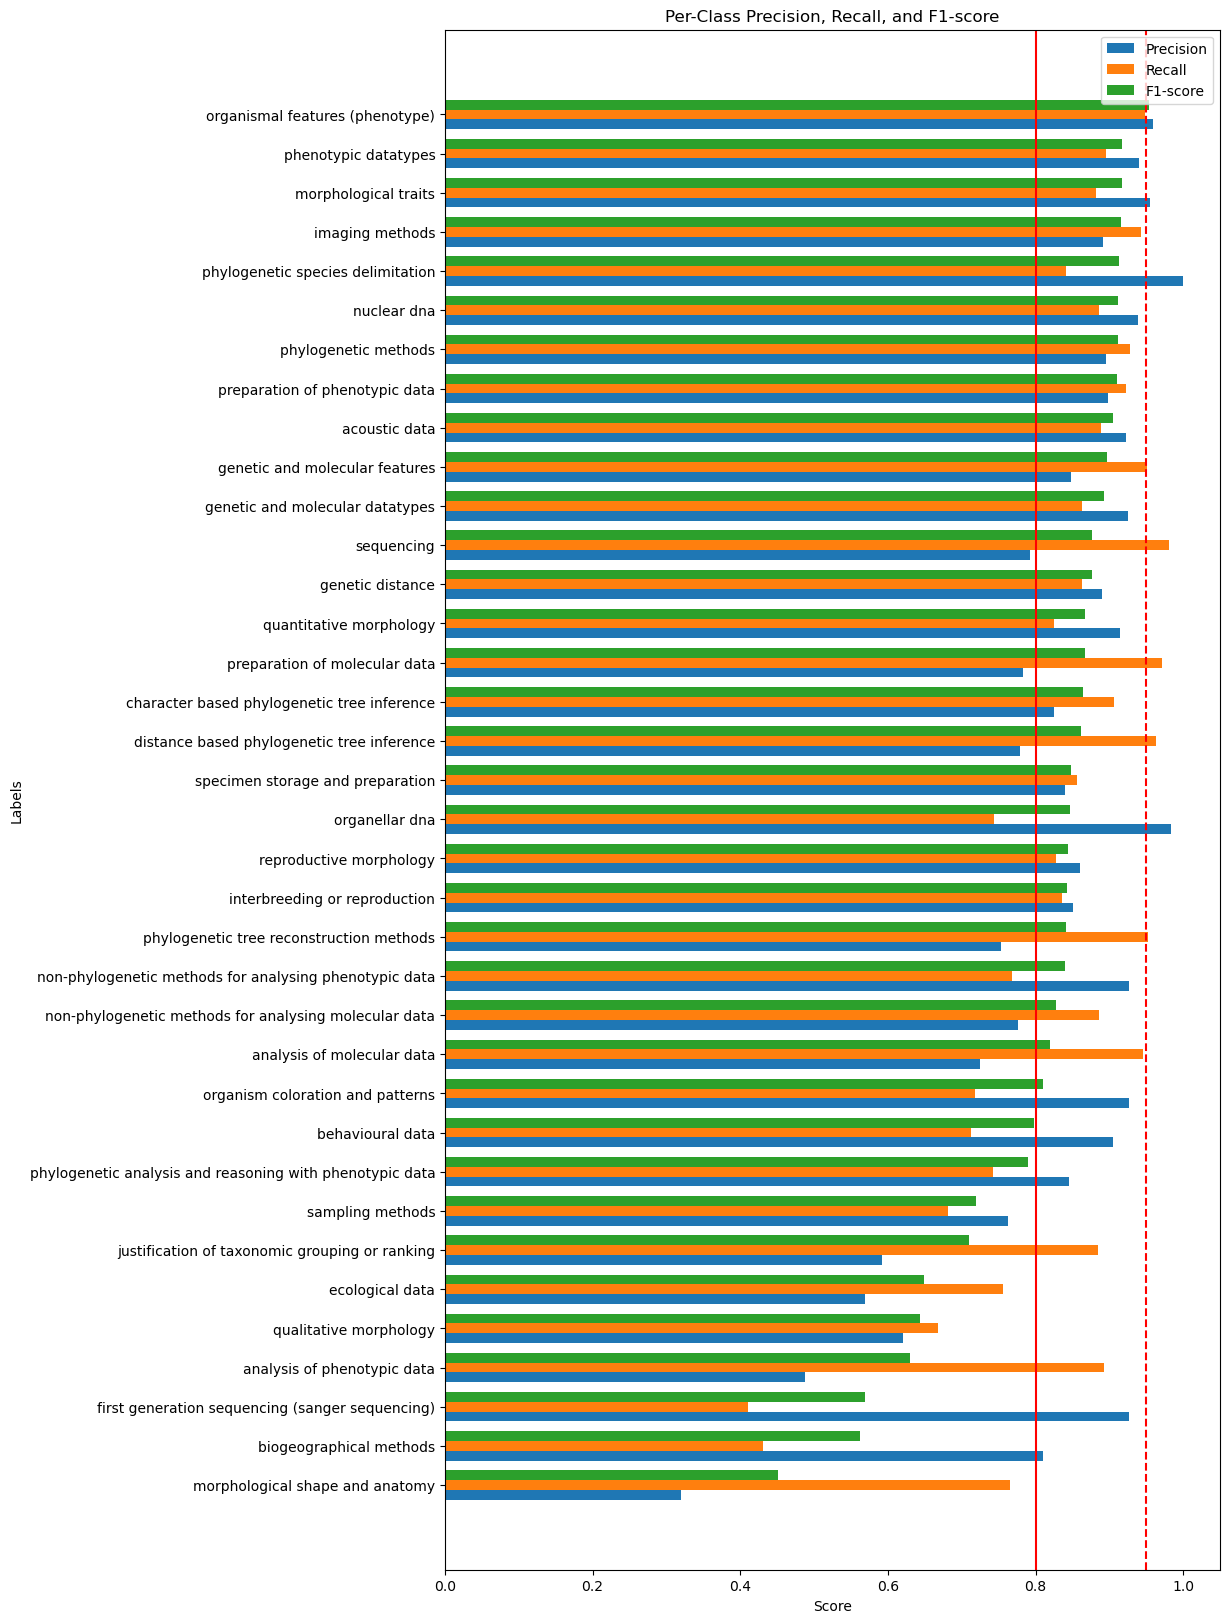

In [272]:
# Compute precision, recall, f1 for each column
precision, recall, f1, _ = precision_recall_fscore_support(df_true, combined_results, average=None)

# Store per-column metrics in a DataFrame
df_metrics3 = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}, index=df_true.columns)
df_metrics3 = df_metrics3.sort_values(by = 'F1-score')

## Compute overall metrics

# first check for all-zeroes on both sides

mask = (df_true.values.sum(axis=1) + combined_results.values.sum(axis=1)) > 0

filtered_df_true = df_true.values[mask]
filtered_df_results = combined_results.values[mask]

f1_micro = f1_score(filtered_df_true, filtered_df_results, average='micro')
f1_macro = f1_score(filtered_df_true, filtered_df_results, average='macro')
f1_weighted = f1_score(filtered_df_true, filtered_df_results, average='weighted')
f1_samples = f1_score(filtered_df_true, filtered_df_results, average='samples')
hamming_loss_result = hamming_loss(filtered_df_true, filtered_df_results)

# Print overall metrics
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print(f"F1 Samples: {f1_samples:.4f}")
print(f"Hamming loss: {hamming_loss_result:.4f}")



# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 20))

# Bar height and index positions
bar_height = 0.25
y = np.arange(len(df_metrics.index))

# Plot horizontal bars for precision, recall, and F1-score
ax.barh(y - bar_height, df_metrics3['Precision'], height=bar_height, label="Precision")
ax.barh(y, df_metrics3['Recall'], height=bar_height, label="Recall")
ax.barh(y + bar_height, df_metrics3['F1-score'], height=bar_height, label="F1-score")

# Customize chart
ax.set_ylabel("Labels")
ax.set_xlabel("Score")
ax.set_title("Per-Class Precision, Recall, and F1-score")
ax.set_yticks(y)
ax.set_yticklabels(df_metrics3.index)
ax.legend(loc = 'upper right')
ax.axvline(0.8, color = 'r')
ax.axvline(0.95, color = 'r', ls = '--')


# Show plot
plt.show()


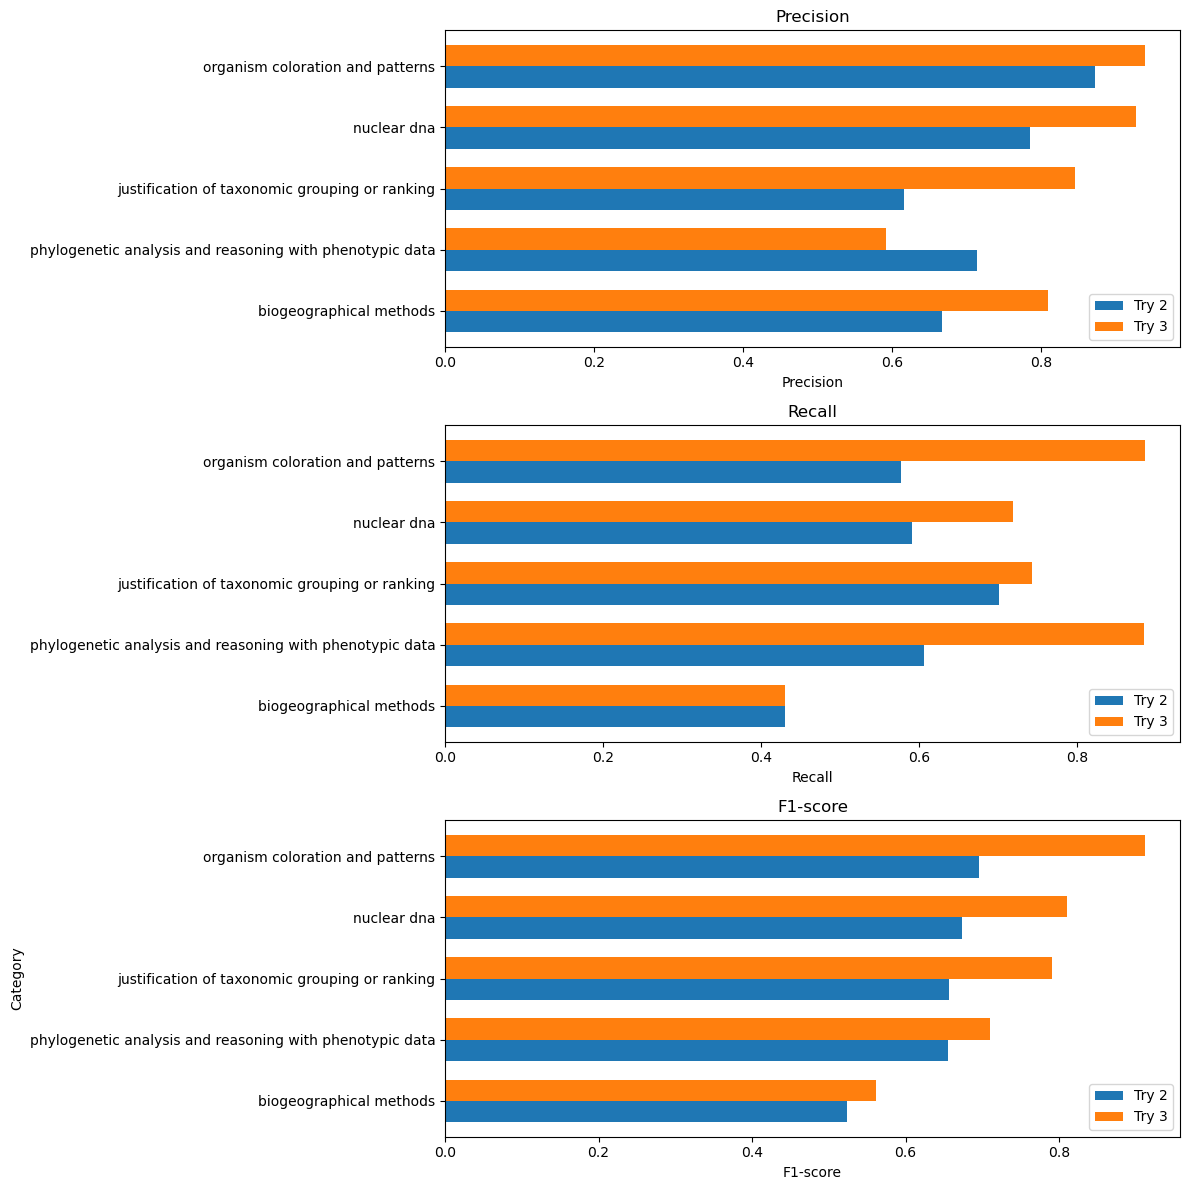

In [277]:
metrics = ["Precision", "Recall", "F1-score"]

# Create subplots: one row per metric.
n_metrics = len(metrics)
y = np.arange(len(methods_bad_new_names))  # the y locations for the groups
bar_height = 0.35  # height of the bars

fig, axes = plt.subplots(n_metrics, 1, figsize=(12,12), sharey=True)

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.barh(y - bar_height/2, df_metrics2.loc[df_metrics2.index.isin(methods_bad_new_names), metric].values, height=bar_height, label="Try 2")
    ax.barh(y + bar_height/2, df_metrics3.loc[df_metrics3.index.isin(methods_bad_new_names), metric], height=bar_height, label="Try 3")
    ax.set_title(metric)
    ax.set_xlabel(metric)
    ax.set_yticks(y)
    ax.set_yticklabels(df_metrics2.loc[df_metrics2.index.isin(methods_bad_new_names)].index)
    ax.legend()

plt.ylabel("Category")
plt.tight_layout()
plt.show()


F1 Micro: 0.6134
F1 Macro: 0.6080
F1 Weighted: 0.6062
F1 Samples: 0.4575
Hamming loss: 0.1619


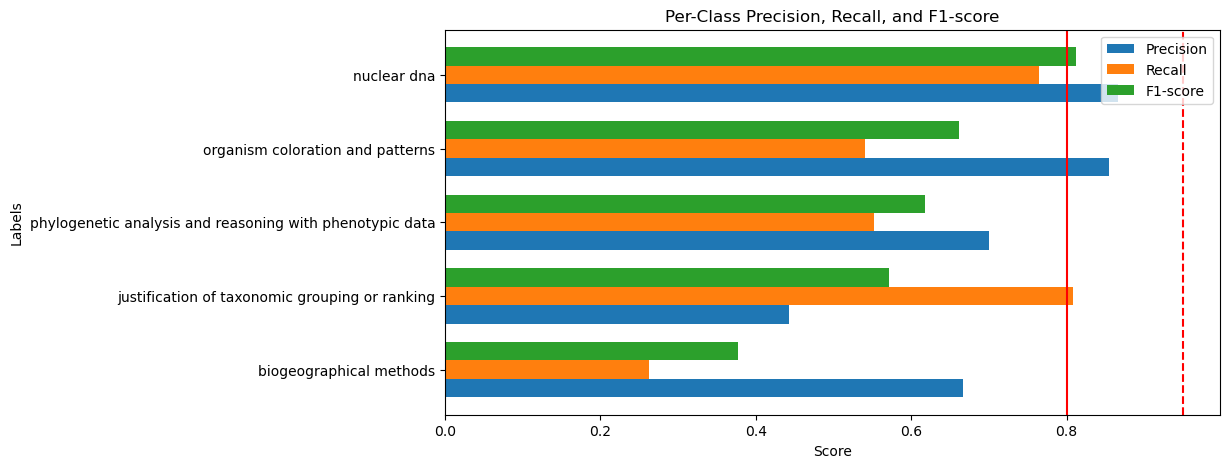

In [280]:
# just the ids and cols that we did with 4o
combined_results_s = combined_results.loc[combined_results.index.isin(df_results4o.index), methods_bad_new_names]
df_true_s = df_true.loc[df_true.index.isin(df_results4o.index), methods_bad_new_names]

# Compute precision, recall, f1 for each column
precision, recall, f1, _ = precision_recall_fscore_support(df_true_s, combined_results_s, average=None)

# Store per-column metrics in a DataFrame
df_metrics4 = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}, index=df_true_s.columns)
df_metrics4 = df_metrics4.sort_values(by = 'F1-score')

## Compute overall metrics

# first check for all-zeroes on both sides

mask = (df_true_s.values.sum(axis=1) + combined_results_s.values.sum(axis=1)) > 0

filtered_df_true = df_true_s.values[mask]
filtered_df_results = combined_results_s.values[mask]

f1_micro = f1_score(filtered_df_true, filtered_df_results, average='micro')
f1_macro = f1_score(filtered_df_true, filtered_df_results, average='macro')
f1_weighted = f1_score(filtered_df_true, filtered_df_results, average='weighted')
f1_samples = f1_score(filtered_df_true, filtered_df_results, average='samples')
hamming_loss_result = hamming_loss(filtered_df_true, filtered_df_results)

# Print overall metrics
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print(f"F1 Samples: {f1_samples:.4f}")
print(f"Hamming loss: {hamming_loss_result:.4f}")



# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 5))

# Bar height and index positions
bar_height = 0.25
y = np.arange(len(df_metrics4.index))

# Plot horizontal bars for precision, recall, and F1-score
ax.barh(y - bar_height, df_metrics4['Precision'], height=bar_height, label="Precision")
ax.barh(y, df_metrics4['Recall'], height=bar_height, label="Recall")
ax.barh(y + bar_height, df_metrics4['F1-score'], height=bar_height, label="F1-score")

# Customize chart
ax.set_ylabel("Labels")
ax.set_xlabel("Score")
ax.set_title("Per-Class Precision, Recall, and F1-score")
ax.set_yticks(y)
ax.set_yticklabels(df_metrics4.index)
ax.legend(loc = 'upper right')
ax.axvline(0.8, color = 'r')
ax.axvline(0.95, color = 'r', ls = '--')


# Show plot
plt.show()
